# Autoencoder
I want to use an autoencoder for dimensionality reduction on the full dataset with 1400+ features. <br>
At the moment, the autoencoder has the following structure. <br>
<br>

![Diagram](AE_diagram.png)
<br>
The input variables are separated into categorical and continuous features. The categorical features are embedded and dropout is added. The continous features are treated with a batchnorm layer. Afterwards, all features are concatenate into a single Tensor. <br>
The encoder is still very basic, consisting of two linear and one ReLu layer, reducing the dimensionality to 128 features. When using the full dataset with over 1400 features, I will probably add another linear layer (plus ReLu) going 512->256->128. <br>
The decoder is the exact inverse of the encoder.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

For now, I'll use the smaller, manually reduced, dataset to make testing faster. When everything is working well, I will run this on the full dataset.

In [3]:
df = pd.read_csv('dataset_reduced.csv')

In [4]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].astype('float64')
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].astype('float64')
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype('float64')

In [5]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,client_installments_AMT_INSTALMENT_max_mean,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum
0,100002.0,1.0,Cash loans,M,406597.5,24700.5,Secondary / secondary special,Single / not married,0.018801,-9461.0,...,53093.746,219625.700,53093.746,219625.700,175783.73,175783.73,219625.700,219625.690,1008781.200,4.172888e+06
1,100003.0,0.0,Cash loans,F,1293502.5,35698.5,Higher education,Married,0.003541,-16765.0,...,175764.050,80773.380,560835.400,453952.220,1154108.20,1154108.20,1150977.400,1618864.600,4394101.500,1.134881e+07
2,100004.0,0.0,Revolving loans,M,135000.0,6750.0,Secondary / secondary special,Single / not married,0.010032,-19046.0,...,10573.965,21288.465,10573.965,21288.465,16071.75,16071.75,21288.465,21288.465,31721.895,6.386539e+04
3,100006.0,0.0,Cash loans,F,312682.5,29686.5,Secondary / secondary special,Civil marriage,0.008019,-19005.0,...,66116.266,25091.324,691786.900,232499.700,994476.70,994476.70,691786.900,1007153.400,1057860.200,3.719995e+06
4,100007.0,0.0,Cash loans,M,513000.0,21865.5,Secondary / secondary special,Single / not married,0.028663,-19932.0,...,12677.324,18330.390,22678.785,172669.890,483756.38,825845.80,280199.700,806127.940,836703.400,1.139621e+07


In [6]:
for column in df.columns:
    if df[column].dtype != 'float64':
        df[column] = df[column].astype('category')

To determine the size of categorical feature embeddings, I use a rule of thumb developed by the FastAI team. <br>

In [7]:
def emb_sz_rule(n_cat): return round(1.6 * n_cat**0.56) ## rule of thumb

def def_emb_sz(df):
    sz_dict = {}
    n_cat = df.nunique().values
    sz = [(x, emb_sz_rule(x)) for x in n_cat]

    return sz

In [8]:
## a helper function that takes in the base dataset, does some preprocessing and returns the dataset split into train/test and categorical/continuous variables
def load_data(df, valid_size=0.2):
    x = df.drop(columns=['SK_ID_CURR', 'TARGET', 'test'])
    x = x.replace([np.inf, -np.inf], np.nan) ## only needed for the reduced dataset, remove this when ready

    ## train test split
    ix = int(len(df)*valid_size)
    x = x.sample(frac=1).reset_index() ## shuffle
    x['valid'] = False
    x.loc[0:ix, 'valid'] = True

    
    ## handle categorical variables
    x_cat = x.select_dtypes(['category', 'bool'])
    x_cat = x_cat.apply(preprocessing.LabelEncoder().fit_transform)
    emb_sz = def_emb_sz(x_cat)[:-1] ## the last element is the "valid" variable, drop it
    x_cat_train, x_cat_test = x_cat[x_cat['valid'] == False].drop(columns='valid'), x_cat[x_cat['valid'] == True].drop(columns='valid')
    x_cat_train, x_cat_test = x_cat_train.values.reshape(-1, x_cat_train.shape[1]).astype('int64'), x_cat_test.values.reshape(-1, x_cat_test.shape[1]).astype('int64')
    
    ## handle continuous variables
    x_cont = x.select_dtypes(['float64', 'bool'])
    x_cont = x_cont.fillna(0)
    x_cont_train, x_cont_test = x_cont[x_cont['valid'] == False].drop(columns='valid'), x_cont[x_cont['valid'] == True].drop(columns='valid')
    x_cont_train, x_cont_test = x_cont_train.values.reshape(-1, x_cont_train.shape[1]).astype('float32'), x_cont_test.values.reshape(-1, x_cont_test.shape[1]).astype('float32')
    
    standardizer = preprocessing.StandardScaler()
    x_cont_train = standardizer.fit_transform(x_cont_train) ## only fit on train set
    x_cont_test = standardizer.transform(x_cont_test)
    

    return x_cat_train, x_cat_test, x_cont_train, x_cont_test, emb_sz

In [9]:
## custom dataset class
class AEDataset(Dataset):
    def __init__(self, x_cat, x_cont, emb_sz):
        self.x_cat, self.x_cont,self.emb_sz = x_cat, x_cont, emb_sz
        self.n_cont = self.x_cont.shape[1]
        self.n_cat = self.x_cat.shape[1]
        self.len = self.x_cat.shape[0]

    def __getitem__(self,index):      
        return self.x_cont[index], self.x_cat[index]
    def __len__(self):
        return self.len

In [10]:
def get_datasets(df):
    x_cat_train, x_cat_test, x_cont_train, x_cont_test, emb_sz = load_data(df)
    
    train_dataset = AEDataset(x_cat_train, x_cont_train, emb_sz)
    test_dataset = AEDataset(x_cat_test, x_cont_test, emb_sz)

    return train_dataset, test_dataset

In [11]:
train_dataset, test_dataset = get_datasets(df)

train_dataloader = DataLoader(dataset=train_dataset,batch_size=1024)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=1024)

A very efficient way of adding noise to an input batch is Swap Noise. With a given probability p, a feature value is replaced with a random value of the same feature distribution. <br>
The actual implementation is copied from [EtienneT's](https://github.com/EtienneT/TabularVAE/blob/master/TabularAE.ipynb) Variational Autoencoder for FastAI and adapted for PyTorch.

In [12]:
class BatchSwapNoise(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size()) > (1 - self.p)
            l1 = torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor)
            l2 = (mask.type(torch.LongTensor) * x.size(1))
            res = (l1 * l2).view(-1)
            idx = torch.arange(x.nelement()) + res
            idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
            return x.flatten()[idx].view(x.size())
        else:
            return x

In [37]:
## apply BatchNorm, Dropout and Linear Layer
class LinBnDrop(nn.Sequential):
    def __init__(self, n_in, n_out, p):
        layers = [nn.BatchNorm1d(n_in), nn.Dropout(p), nn.Linear(n_in, n_out)]
        super().__init__(*layers)

In [44]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, emb_szs, n_cont, dropout=0.2, noise=0.1):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in emb_szs])  
        n_emb = sum([size for categories,size in emb_szs]) #sum embedding sizes
        n_cat = sum([categories for categories,size in emb_szs]) ## sum category labels
        self.n_emb, self.n_cont, self.n_cat = n_emb, n_cont, n_cat
        self.n_input = n_emb + n_cont
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.emb_dropout = nn.Dropout(dropout)
        self.bn_cont = nn.BatchNorm1d(self.n_cont)
        self.noise = BatchSwapNoise(noise)
     
        self.encoder = torch.nn.Sequential(
            LinBnDrop(n_in=self.n_input, n_out=256, p=self.dropout),
            torch.nn.ReLU(),
            LinBnDrop(n_in=256, n_out=128, p=self.dropout),
        )
          

        self.decoder = torch.nn.Sequential(
            LinBnDrop(n_in=128, n_out=256, p=self.dropout),
            torch.nn.ReLU(),
            LinBnDrop(n_in=256, n_out=self.n_input, p=self.dropout),
        )
        
    
    ## function to turn embeddings into label probabilities
    def decode_embeddings(self, values, proba=False):

        softmax = torch.nn.Softmax(dim=1)
        
        start = 0

        out = torch.empty((values.shape[0],0), requires_grad=True).long().to(device)

        ### loop through each embedding
        ## TODO: there has to be a better way to do this than a loop
        for emb in self.embeddings:
            
            stop = start + emb.weight.data.shape[1]
            
            pred = torch.empty((0,emb.weight.data.shape[0])).to(device) ## create empty tensor of size (0,n) where n is the number of feature labels
                
            distance = ((emb.weight.data.unsqueeze(0) - values[:,start:stop].unsqueeze(1))**2).sum(axis=2) 

            p = softmax(-distance)
                    
            out = torch.cat([out,p],axis=1)
            start = stop  

        return out
    
    

    def forward(self, x_cont, x_cat, encode=False):

        x_cat = x_cat.to(device)
        x_cont = x_cont.to(device)
        
        ## add batch swap noise
        x_cat = self.noise(x_cat)
        x_cont = self.noise(x_cont)

        ## embedd categorical features and add dropout
        x = [emb(x_cat[:,i]) for i, emb in enumerate(self.embeddings)]   
        x = torch.cat(x, 1)
        x = self.emb_dropout(x)

        ## batch norm on continuous features
        x2 = self.bn_cont(x_cont)
        
        ## concat cat and cont features
        x = torch.cat([x, x2], 1) 
        
        ## encode features
        x = self.encoder(x)
        
        ## if I only want to encode features, stop here
        if encode:
            return x
        
        
        ## decode encoded features
        x = self.decoder(x)
        
        ## get continuous features
        x_cont_out = x[:,self.n_emb:]
        
        ## get categorical features and reverse embedding
        x_cat_out = x[:,0:self.n_emb]
        x_cat_out = self.decode_embeddings(x_cat_out)
        

        return x_cont_out, x_cat_out

In [45]:
len_x = train_dataset.len
len_cont = train_dataset.n_cont
emb_sz = train_dataset.emb_sz
model = AutoEncoder(emb_sz, len_cont).to(device)

In [46]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
    
    def forward(self, x_cont_ae, x_cat_ae, x_cont, x_cat):
                    
        ## loss for the continuous features is simply MSE
        cont_loss = self.mse_loss(x_cont_ae, x_cont)
        
        ## the input categorical features are label encoded, but one-hot encoding is needed to calculate cross entropy loss
        one_hot = torch.empty((x_cat.shape[0],0), requires_grad=True).long().to(device)
        
        for i in range(x_cat.shape[1]):
            n_classes = train_dataset.x_cat[:,i].max() + 1 ## not every label is present in a batch, so I have to supply the amount of feature labels   
            out = nn.functional.one_hot(x_cat[:,i], num_classes=n_classes).to(device)
            one_hot = torch.cat([one_hot,out], axis=1)
        
        one_hot = one_hot.float()

    
        ## now I can easily calculate cross entropy loss
        cat_loss = self.ce_loss(x_cat_ae, one_hot)
        
        ## take the sum as the final output
        loss = cont_loss + cat_loss
        
        return loss

In [47]:
loss_function = customLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

In [48]:
epochs = 100
val_losses = []
train_losses = []
patience = 5

In [49]:
for e in range(epochs):
    tstart = time.time()
    
    ## train
    train_loss = 0.0
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        
        x_cont, x_cat = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        x_cont_ae, x_cat_ae = model(x_cont, x_cat)
        
        loss = loss_function(x_cont_ae, x_cat_ae, x_cont, x_cat)
        loss.backward()

        optimizer.step()
        
        train_loss += loss.item()

    ## validate
    valid_loss = 0.0
    model.eval()
    for batch_idx, data in enumerate(test_dataloader):
        
        x_cont, x_cat = data[0].to(device), data[1].to(device)
         
        x_cont_ae, x_cat_ae = model(x_cont, x_cat)
        
        loss = loss_function(x_cont_ae, x_cat_ae, x_cont, x_cat)
        
        valid_loss += loss.item()

    train_losses.append(train_loss / len(train_dataloader.dataset))
    val_losses.append(valid_loss / len(test_dataloader.dataset))
 

    tend = time.time()
    print('Epoch {}. Train loss: {:.2f}. Valid loss: {:.2f}. Time: {:.2f}s'.format(e, train_losses[-1], val_losses[-1], tend-tstart))

    if (e > patience) & (min(val_losses[-patience:]) != min(val_losses)):
        print('No improvement for {} epochs. Ending training.'.format(patience))
        break

Epoch 0. Train loss: 223.60. Valid loss: 153.00. Time: 5.23s
Epoch 1. Train loss: 188.95. Valid loss: 138.80. Time: 5.14s
Epoch 2. Train loss: 181.60. Valid loss: 130.54. Time: 5.46s
Epoch 3. Train loss: 176.97. Valid loss: 125.56. Time: 5.21s
Epoch 4. Train loss: 173.96. Valid loss: 122.50. Time: 5.25s
Epoch 5. Train loss: 172.12. Valid loss: 120.24. Time: 5.28s
Epoch 6. Train loss: 170.83. Valid loss: 118.82. Time: 5.14s
Epoch 7. Train loss: 170.23. Valid loss: 118.15. Time: 5.16s
Epoch 8. Train loss: 169.50. Valid loss: 117.04. Time: 5.36s
Epoch 9. Train loss: 168.90. Valid loss: 116.67. Time: 5.61s
Epoch 10. Train loss: 168.60. Valid loss: 116.17. Time: 5.34s
Epoch 11. Train loss: 168.39. Valid loss: 115.79. Time: 5.30s
Epoch 12. Train loss: 167.90. Valid loss: 115.52. Time: 5.40s
Epoch 13. Train loss: 167.79. Valid loss: 115.18. Time: 5.48s
Epoch 14. Train loss: 167.09. Valid loss: 114.95. Time: 5.51s
Epoch 15. Train loss: 167.16. Valid loss: 114.79. Time: 5.23s
Epoch 16. Train lo

## Preliminary Result
The model converges pretty fast at a loss of around 164 during training and 111 during validation. A lower loss during validation looks concerning at first, but it should be expected since no regularization is applied during validation. <br>
It is a very good sign that both curves are basically parallel. It looks like the model is able to find meaningful representations of the data. <br>
I will try to improve performance a bit before moving on to the full dataset, as I expect significantly longer run times with 7x the feature count.

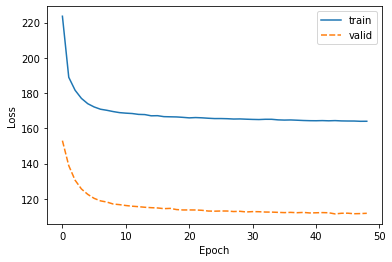

In [50]:
plot_df = pd.DataFrame({'train': train_losses, 'valid': val_losses})
ax = sns.lineplot(data=plot_df)
ax.set(xlabel='Epoch', ylabel='Loss')
plt.show()